In the lecture, we discussed the simple genetic algorithm. Now, we will try to use it to solve two simple problems - OneMAX and subset sum.

In the end, we will discuss the `deap` library, that can be used for implementation of more complex evolutionary algorithms.

The implementation is very simple, we will start by writing the high-level version of the algorithm (it is almost a pseudo-code).

In [3]:
import numpy as np

def evolution(pop_size, ind_size, max_gen, fitness, cx_pb = 0.8, mut_pb=0.1, per_bit_pb = 0.2):
    population = random_population(pop_size, ind_size)
    log = []

    for i in range(max_gen):
        fit = [fitness(ind) for ind in population]
        log.append(max(fit))
        mating_pool = selection(population, fit, pop_size)
        offspring = crossover(mating_pool, cx_pb)
        offspring = mutation(offspring, mut_pb, per_bit_pb)
        population = offspring[:] # shallow copy
    
    fit = list(map(fitness, population))
    best = population[np.argmax(fit)]
    return best, population, log

Now we need to write implementations of the functions used above. We start by initializing a random population - we will only consider individuals that are lists of 1's and 0's.

In [4]:
import random

def random_population(pop_size, ind_size):
    pop = []
    for _ in range(pop_size):
        ind = [0 if random.random() < 0.5 else 1 for _ in range(ind_size)]
        pop.append(ind)
    
    return pop

random_population(5, 10)

[[0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 0, 1, 1, 0, 0, 1, 1, 1, 1],
 [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]]

Next, we implement the roulette-wheel selection - it's simple, the `random` module contains the `choices` function, which does exactly what we need.

In [5]:
import copy

def selection(pop, fit, N):
    return copy.deepcopy(random.choices(pop, weights=fit, k=N)) # make a deep copy so that
                                                                # we have unique indivduals

Now we implement the one-point crossover and a mutation that changes random bits (bit flip mutation). For both operators, we expect to receive the entire population.

In [6]:
def crossover(pop, cx_pb = 0.8):
    new_pop = []
    for i in range(len(pop)//2):
        
        o1 = copy.deepcopy(pop[2*i])
        o2 = copy.deepcopy(pop[2*i + 1])
        
        if random.random() < cx_pb: # crossover probability
            point = random.randrange(0, len(o1))
            o2_start = o2[:point]
            o2[:point] = o1[:point]
            o1[:point] = o2_start[:]
        
        new_pop.append(o1)
        new_pop.append(o2)
    
    return new_pop

def mutation(pop, mut_pb = 0.1, per_bit_pb = 0.2):
    new_pop = []
    for ind in pop:
        
        o = copy.deepcopy(ind)
        
        if random.random() < mut_pb: # mutation probability
            o = [1-x if random.random() < per_bit_pb else x for x in o] # change the bit to the othex value with per_bit_pb probability
        
        new_pop.append(o)
    
    return new_pop

import pprint
pop = random_population(6, 10)
print('population')
pprint.pprint(pop)
print('after crossover')
pprint.pprint(crossover(pop))
print('after mutation')
pprint.pprint(mutation(pop, mut_pb=1.0))

population
[[0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
after crossover
[[0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
after mutation
[[0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 1]]


And that completes the algorithm. We only need to write a fitness function. We want to solve the OneMAX problem - fitness will therefore be the number of 1s in an individual.

In [7]:
def onemax(ind):
    return sum(ind)

pop = random_population(6, 10)
fit = [onemax(ind) for ind in pop]
for i,f in zip(pop, fit):
    print((i, f))

([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], 2)
([1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 9)
([0, 0, 1, 1, 1, 1, 0, 0, 0, 0], 4)
([1, 1, 0, 0, 0, 1, 0, 1, 1, 1], 6)
([1, 0, 1, 1, 1, 1, 1, 0, 0, 1], 7)
([1, 0, 1, 1, 1, 0, 0, 1, 1, 0], 6)


Let's start our algorithm and see how it works.

In [8]:
best, pop, log = evolution(pop_size = 100, ind_size = 50, max_gen = 50, fitness = onemax)

best fitness:  42
best:  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


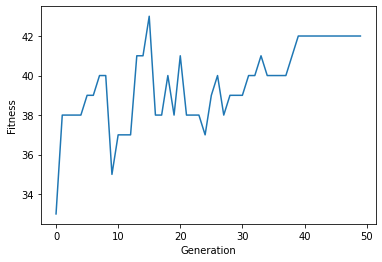

In [9]:
print('best fitness: ', onemax(best))
print('best: ', best)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(log)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

## Exercise

Try to adapt the algorithm above so that it solves the subset sum problem, i.e. find a subset of a givet set, such that its sum is exactly a given number. In the optimization version of this problem, we aim to minimize the difference between the sum of the subset and the given value.

You can generate the input randomly.

In [50]:
ind_size = 100  # try 1000
input_set = [random.randrange(0,50) + 100 for _ in range(ind_size)] # ind_size random numbers between 100 and 150
number = sum(input_set)//2

total = sum(input_set)

print(number, input_set)

6226 [130, 100, 117, 132, 124, 147, 109, 106, 100, 147, 138, 134, 103, 141, 137, 126, 119, 142, 141, 112, 126, 109, 149, 128, 139, 103, 133, 149, 142, 107, 142, 133, 110, 106, 113, 147, 108, 104, 131, 128, 120, 144, 149, 101, 125, 114, 149, 113, 118, 141, 112, 119, 144, 120, 111, 143, 110, 107, 124, 129, 130, 138, 101, 132, 105, 142, 116, 128, 102, 109, 145, 132, 129, 103, 126, 134, 115, 116, 137, 121, 118, 103, 119, 140, 112, 138, 132, 111, 147, 126, 119, 134, 124, 130, 139, 138, 123, 105, 117, 112]


In [53]:
import numpy as np


# You can also work with np.arrays and multiply the input_set with it
def get_subset(ind):
    return [input_set[i] for i, val in enumerate(ind) if val > 0.1]


# or choose a different fitness, e.g. 1 / (diff + 1), squared error...
def subset_sum_fitness(ind):
    return total - objective(ind)

# this is what we want to minimize
def objective(ind):
    return np.abs(sum(get_subset(ind)) - number)


def get_overall_best(overall_best, fitness_best, population, fitnesses):
    best_id = np.argmax(fitnesses)
    best = population[best_id]
    best_fit = fitnesses[best_id]
    
    if overall_best is None:
        overall_best = best
        fitness_best = best_fit
    else:
        overall_best = overall_best if best_fit <= fitness_best else best
        fitness_best = fitness_best if best_fit <= fitness_best else best_fit

    return overall_best, fitness_best


def evolution(pop_size, ind_size, max_gen, fitness, cx_pb = 0.8, mut_pb=0.1, per_bit_pb = 0.2):
    population = random_population(pop_size, ind_size)
    log = []
    
    overall_log = []
    fitness_best = None
    overall_best = None
    
    for i in range(max_gen):
        fit = [fitness(ind) for ind in population]
        log.append(max(fit))
        
        # also log overall best individual
        overall_best, fitness_best = get_overall_best(overall_best, fitness_best, population, fit)
        overall_log.append(objective(overall_best))

        mating_pool = selection(population, fit, pop_size)
        offspring = crossover(mating_pool, cx_pb)
        offspring = mutation(offspring, mut_pb, per_bit_pb)
        population = offspring[:] # shallow copy
    
    fit = list(map(fitness, population))
    best = population[np.argmax(fit)]
    return best, population, log, overall_best, overall_log

best fitness:  12452
best number:  6227 | given number:  6226
best diff:  1


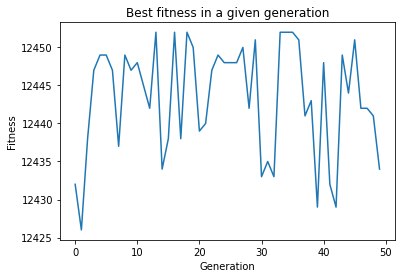

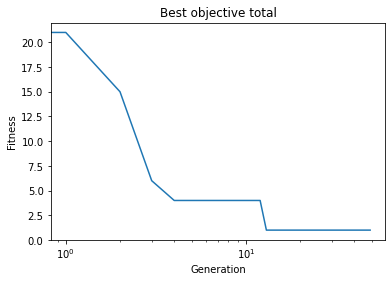

In [55]:
best, pop, log, overall, overall_log = evolution(pop_size = 100, ind_size = ind_size, max_gen = 50, fitness = subset_sum_fitness)

print('best fitness: ', subset_sum_fitness(overall))
print('best number: ', sum(get_subset(overall)), "| given number: ", number)
print('best diff: ', sum(get_subset(overall)) - number)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(log)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.title("Best fitness in a given generation")
plt.show()

plt.plot(overall_log)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.title("Best objective total")
plt.xscale('log')
plt.show()

## `deap`library 

We saw that implementing an evolutionary algorithms is simple, however, very often it is better to use an existing library to simplify the implementation (and avoid bugs). One of the most popular libraries is `deap`. Its tutorial is well-written and - [contains the same problem we solved above][1].

  [1]: https://deap.readthedocs.io/en/master/examples/ga_onemax.html